# import

In [1]:
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
import phik 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 

# first look

In [2]:
df = pd.read_csv('Churn.csv')

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


План работы: 

1) EDA
2) Baseline модель (логрег + рандом форест + матрица метрик)
3) Работа с балансом классов: 
    а) взвешениевание весов 
    б) даунсемплинг 
    в) апсемплинг 
4) работа с roc auc и поиск трешхолда 
4) выводы 


# eda

## data quality

In [5]:
df.isnull().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
df.columns = [col.lower() for col in df.columns]
df.columns

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited'],
      dtype='object')

In [8]:
df = df.set_index('customerid').drop(['rownumber', 'surname'], axis = 1)

## features

In [9]:
df.describe(percentiles=[0, 0.5, 0.8, 0.9, 0.95]).round(0)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
count,10000.0,10000.0,9091.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
mean,651.0,39.0,5.0,76486.0,2.0,1.0,1.0,100090.0,0.0
std,97.0,10.0,3.0,62397.0,1.0,0.0,0.0,57510.0,0.0
min,350.0,18.0,0.0,0.0,1.0,0.0,0.0,12.0,0.0
0%,350.0,18.0,0.0,0.0,1.0,0.0,0.0,12.0,0.0
50%,652.0,37.0,5.0,97199.0,1.0,1.0,1.0,100194.0,0.0
80%,735.0,46.0,8.0,133710.0,2.0,1.0,1.0,159837.0,1.0
90%,778.0,53.0,9.0,149245.0,2.0,1.0,1.0,179675.0,1.0
95%,812.0,60.0,9.0,162712.0,2.0,1.0,1.0,190155.0,1.0
max,850.0,92.0,10.0,250898.0,4.0,1.0,1.0,199992.0,1.0


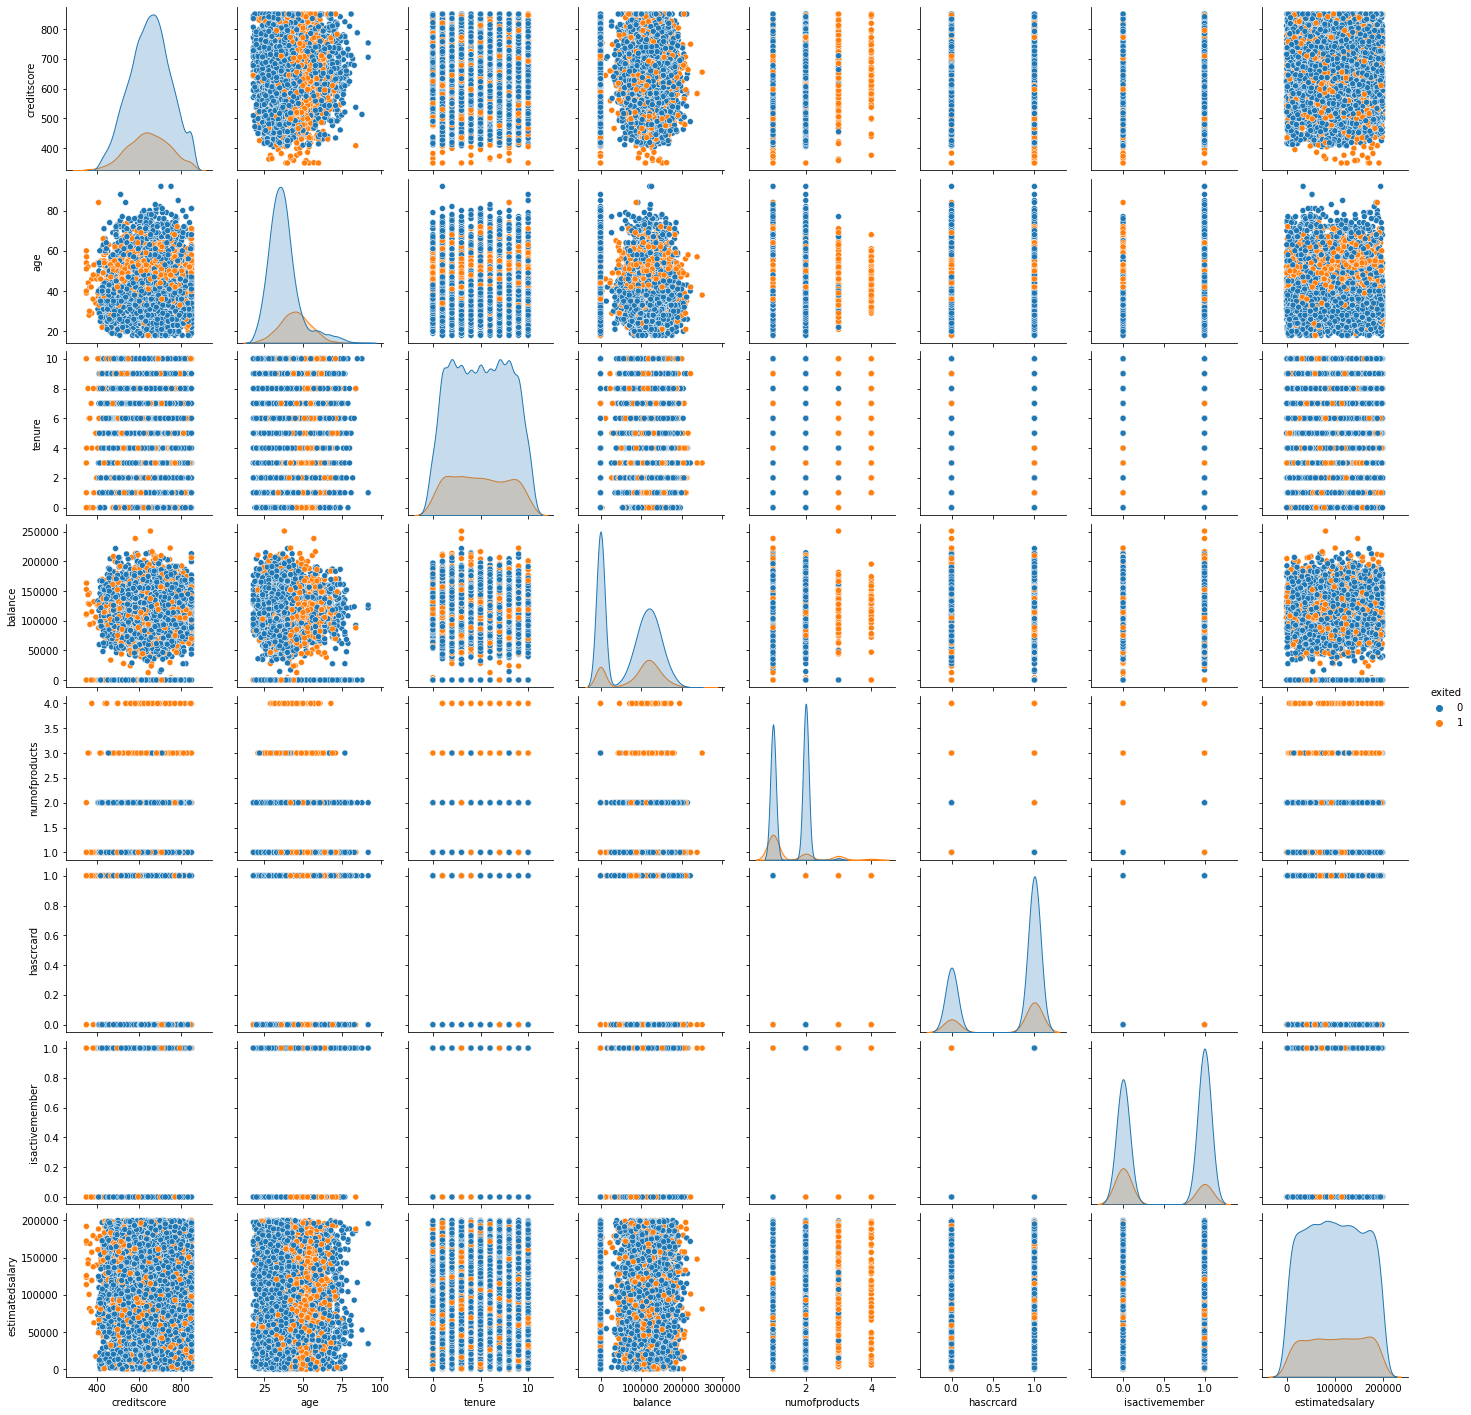

In [10]:
sns.pairplot(df, hue = 'exited')

При первом взгляде на фичи уже есть пара инсайтов: 

- кажется, что теряем мы в основном возрастную адиторию 
- сильно больше потерь у нас у клиентов с более чем 2 продуктами

CREDITSCORE
----------------------------------------------------------------------------------------------------
count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
0%         350.000000
50%        652.000000
80%        735.000000
95%        812.000000
max        850.000000
Name: creditscore, dtype: float64


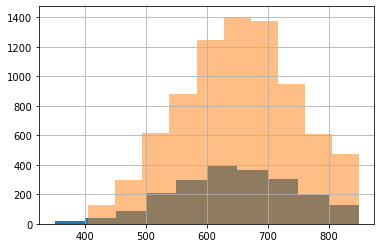

AGE
----------------------------------------------------------------------------------------------------
count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
0%          18.000000
50%         37.000000
80%         46.000000
95%         60.000000
max         92.000000
Name: age, dtype: float64


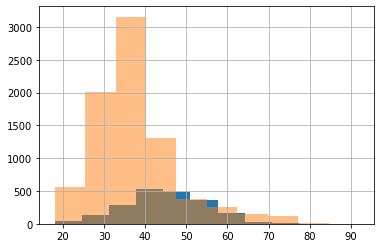

BALANCE
----------------------------------------------------------------------------------------------------
count     10000.000000
mean      76485.889288
std       62397.405202
min           0.000000
0%            0.000000
50%       97198.540000
80%      133710.358000
95%      162711.669000
max      250898.090000
Name: balance, dtype: float64


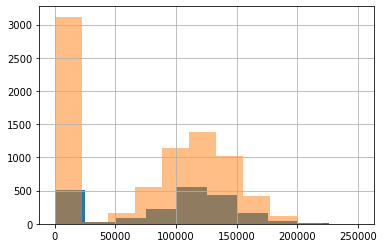

ESTIMATEDSALARY
----------------------------------------------------------------------------------------------------
count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
0%           11.580000
50%      100193.915000
80%      159836.726000
95%      190155.375500
max      199992.480000
Name: estimatedsalary, dtype: float64


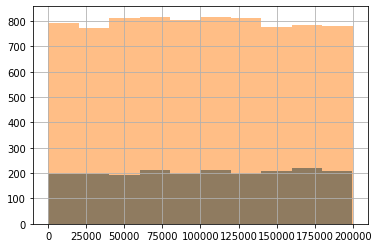

TENURE
----------------------------------------------------------------------------------------------------
count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
0%          0.000000
50%         5.000000
80%         8.000000
95%         9.000000
max        10.000000
Name: tenure, dtype: float64


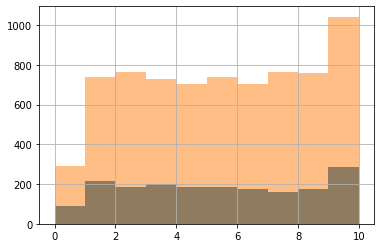

In [11]:
for col in ['creditscore', 'age', 'balance', 'estimatedsalary', 'tenure']:
    print('='*100)
    print(col.upper())
    print('-'*100)
    print(df[col].describe(percentiles=[0, 0.5, 0.8, 0.95]))
    df.query('exited == 1')[col].hist()
    df.query('exited == 0')[col].hist(alpha = 0.5)
    plt.show()

Если посмотреть на распределение групп по возрасту, то инсайт про возраст подтверждается. 

In [12]:
for col in ['geography', 'gender', 'numofproducts', 'hascrcard', 'isactivemember']:
    print('='*100)
    print(col.upper())
    print(df.groupby(col).agg({'exited':'mean'}))

GEOGRAPHY
             exited
geography          
France     0.161548
Germany    0.324432
Spain      0.166734
GENDER
          exited
gender          
Female  0.250715
Male    0.164559
NUMOFPRODUCTS
                 exited
numofproducts          
1              0.277144
2              0.075817
3              0.827068
4              1.000000
HASCRCARD
             exited
hascrcard          
0          0.208149
1          0.201843
ISACTIVEMEMBER
                  exited
isactivemember          
0               0.268509
1               0.142691


в категориальных переменных можно посомтреть на долю потерянных клиентов.

например большая разница есть в ISACTIVEMEMBERб GEOGRAPHY, GENDER. 

### corr

In [13]:
#взял фик, так как есть категориальные переменные 
phm = phik.phik_matrix(df)

interval columns not set, guessing: ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary', 'exited']


In [14]:
phm['exited'].sort_values(ascending=False)

exited             1.000000
numofproducts      0.565084
age                0.487524
isactivemember     0.241939
balance            0.183365
gender             0.165422
geography          0.104511
creditscore        0.096525
tenure             0.020845
hascrcard          0.000000
estimatedsalary    0.000000
Name: exited, dtype: float64

таргет коррелирует с количеством продуктов (возможно из-за малого количества людей с 3 и 4 продуктами), возрастом и маркером активности юзера. 

<AxesSubplot:>

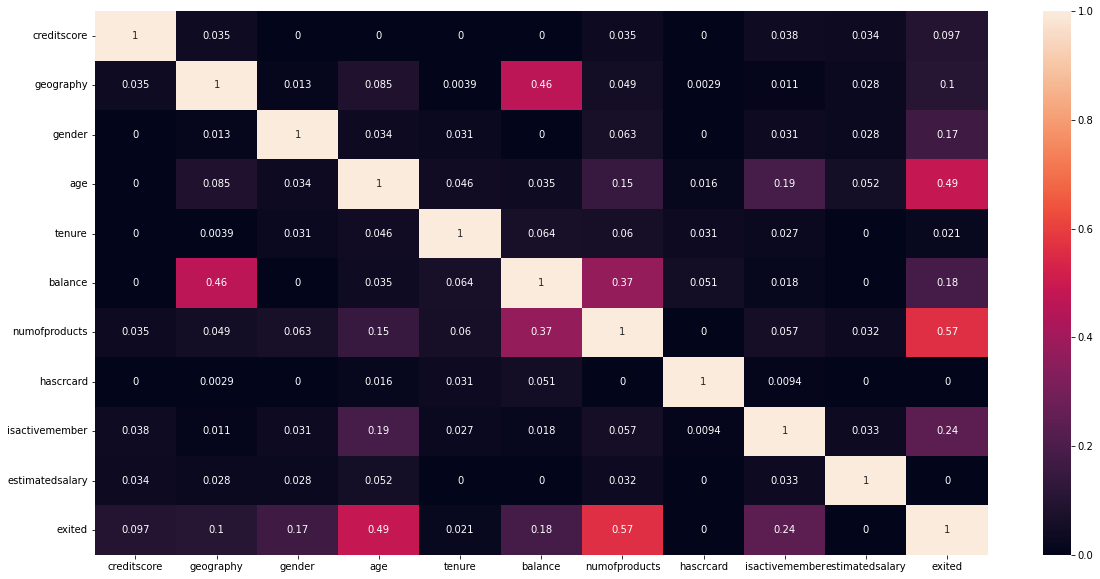

In [15]:
plt.figure(figsize=(20,10))
sns.heatmap(phm, annot=True)

# models

## base line

In [16]:
df_transformed = pd.get_dummies(df).drop(['gender_Female', 'geography_France'], axis = 1)
df_transformed.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
customerid,,,,,,,,,,,,
15634602,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
15647311,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
15619304,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
15701354,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
15737888,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [17]:
df_transformed.exited.value_counts(normalize=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

датасет не худшший (в плане балансировки), 20% -- это тебе не 1%. 

In [18]:
print(df_transformed[df_transformed['tenure'].isnull()]['exited'].mean())
df_transformed['tenure'].fillna(df_transformed['tenure'].median(), inplace=True)

0.20132013201320131


In [20]:
features = df_transformed.drop(['exited'], axis = 1)
target = df_transformed['exited']

#train (train + valid) | test
X_train, x_test, Y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
#train | valid
x_train, x_valid, y_train, y_valid  = train_test_split(X_train, Y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

In [21]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(x_train)
x_train_sc = sc.transform(x_train)
x_valid_sc = sc.transform(x_valid)

In [22]:
model = LogisticRegression()

model.fit(x_train_sc, y_train)
pred_train = model.predict(x_train_sc)
pred = model.predict(x_valid)

print(f1_score(y_train, pred_train))
print(f1_score(y_valid, pred))
print(roc_auc_score(y_valid, pred))

0.3184019370460049
0.35985748218527314
0.5618501413573663


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [23]:
best_model_forest = None
f1_score_max = 0 
best_roc_auc = 0

for depth in range(3,10):
    for n_est in range(5,100,15):
        model = RandomForestClassifier(max_depth=depth, random_state= 42, n_estimators= n_est)
        model.fit(x_train, y_train)

        pred_train = model.predict(x_train)
        pred = model.predict(x_valid)

        print(depth, n_est)
        print('train f1', f1_score(y_train, pred_train))
        print('train roc_auc', roc_auc_score(y_train, pred_train))

        f1_valid = f1_score(y_valid, pred)
        roc_auc = roc_auc_score(y_valid, pred)

        print('valid f1', f1_valid)
        print('valid roc_auc', roc_auc)

        
        if roc_auc > best_roc_auc:
            best_roc_auc = roc_auc
            best_model_forest = model

3 5
train f1 0.337696335078534
train roc_auc 0.6007039438125901
valid f1 0.3359375
valid roc_auc 0.6000204445624329
3 20
train f1 0.3473132372214941
train roc_auc 0.604490754754295
valid f1 0.3713733075435203
valid roc_auc 0.6137022813995676
3 35
train f1 0.3253012048192771
train roc_auc 0.5966033680490318
valid f1 0.34970530451866405
valid roc_auc 0.6055427649897549
3 50
train f1 0.23897581792318634
train roc_auc 0.5675032990446185
valid f1 0.24421052631578943
valid roc_auc 0.5689576782300502
3 65
train f1 0.19970845481049562
train roc_auc 0.5552264412783685
valid f1 0.20346320346320343
valid roc_auc 0.5562706066695045
3 80
train f1 0.21371841155234658
train roc_auc 0.5594846659792911
valid f1 0.2260127931769723
valid roc_auc 0.5632194693262906
3 95
train f1 0.20754716981132076
train roc_auc 0.5576634843327958
valid f1 0.21120689655172414
valid roc_auc 0.5586919141755576
4 5
train f1 0.5032967032967033
train roc_auc 0.6722930842792412
valid f1 0.5221518987341772
valid roc_auc 0.682744

In [27]:
print(best_model_forest)
print(best_roc_auc)
f1_score(y_valid, best_model_forest.predict(x_valid))

RandomForestClassifier(max_depth=9, n_estimators=50, random_state=42)
0.7134252118071924


0.5820433436532507

In [28]:
best_model_gb = None
f1_score_max = 0 
best_roc_auc_gb = 0 

for depth in range(3,10):
    for n_est in range(5,100,15):
        model = GradientBoostingClassifier(random_state= 42, max_depth=depth, n_estimators=n_est)

        model.fit(x_train, y_train)
        pred_train = model.predict(x_train)
        pred = model.predict(x_valid)

        print(f1_score(y_train, pred_train))
        print(f1_score(y_valid, pred))


        print(depth, n_est)
        print('train f1', f1_score(y_train, pred_train))
        f1_valid = f1_score(y_valid, pred)
        roc_auc = roc_auc_score(y_valid, pred)

        print('valid f1', f1_valid)
        print('valid roc_auc', roc_auc)

        if roc_auc > best_roc_auc_gb:
            best_roc_auc_gb = roc_auc
            best_model_gb = model

0.1368421052631579
0.15521064301552107
3 5
train f1 0.1368421052631579
valid f1 0.15521064301552107
valid roc_auc 0.5414277017718112
0.5108323831242874
0.5513866231647634
3 20
train f1 0.5108323831242874
valid f1 0.5513866231647634
valid roc_auc 0.6948336285589177
0.5542825968357884
0.5597484276729561
3 35
train f1 0.5542825968357884
valid f1 0.5597484276729561
valid roc_auc 0.7013186742769262
0.5945378151260504
0.5771604938271605
3 50
train f1 0.5945378151260504
valid f1 0.5771604938271605
valid roc_auc 0.7112693784700449
0.6096311475409837
0.5875190258751902
3 65
train f1 0.6096311475409837
valid f1 0.5875190258751902
valid roc_auc 0.7175881214040838
0.6179604261796043
0.5894736842105264
3 80
train f1 0.6179604261796043
valid f1 0.5894736842105264
valid roc_auc 0.7196447833562953
0.6232980332829048
0.5907046476761619
3 95
train f1 0.6232980332829048
valid f1 0.5907046476761619
valid roc_auc 0.7205403772479483
0.1044546850998464
0.11818181818181818
4 5
train f1 0.1044546850998464
vali

In [31]:
print(best_model_gb)
print(best_roc_auc_gb)
print(f1_score(y_valid, best_model_gb.predict(x_valid)))

GradientBoostingClassifier(max_depth=7, n_estimators=80, random_state=42)
0.7358150590985169
0.6120689655172414


за baseline взял три модели: градиентный бустинг, лес и логрег. лес или бустинг можно взять для дальнейшего тюнинга. 
логрег не очень интересна, поэтому не стал скалировать данные, хотя как бы надо было конечно. 

Окей, везде поперебирали параметры, лучше всего показал себя бустинг:

GradientBoostingClassifier(max_depth=7, n_estimators=80, random_state=42)
0.7358150590985169 (roc auc)
0.6120689655172414 (f1_score)

## балансировка

### взвешивание классов + подббор гиперпараметров модели

#### RFC balanced

In [32]:
#для примера хочу попробовать случайный лес 
best_model_forest_balanced = None
f1_max = 0 
best_roc_auc = 0 
for depth in range(3,10):
    for n_est in range(5,100,15):
        model = RandomForestClassifier(class_weight='balanced', max_depth=depth, random_state= 42, n_estimators=n_est)
        print(depth, n_est)
        model.fit(x_train, y_train)
        pred_train = model.predict(x_train)
        pred_valid = model.predict(x_valid)
        f1_train = f1_score(y_train, pred_train)
        f1_valid = f1_score(y_valid, pred_valid)
        print('f_1 train', f1_train, 'f_1_valid', f1_valid)
        roc_auc = roc_auc_score(y_valid, pred_valid)
        print('valid roc_auc', roc_auc)
        if roc_auc > best_roc_auc:
            best_model_forest_balanced = model
            best_roc_auc = roc_auc
        print('='*100)

3 5
f_1 train 0.5201149425287357 f_1_valid 0.5281690140845071
valid roc_auc 0.7299258045469318
3 20
f_1 train 0.5727818124407957 f_1_valid 0.56657223796034
valid roc_auc 0.7541854138727037
3 35
f_1 train 0.5674390968508616 f_1_valid 0.5643300798580303
valid roc_auc 0.7602241883585001
3 50
f_1 train 0.5643327348892879 f_1_valid 0.5842490842490843
valid roc_auc 0.7727769971209784
3 65
f_1 train 0.5691842900302116 f_1_valid 0.5806451612903225
valid roc_auc 0.7688795616929928
3 80
f_1 train 0.5720351835001516 f_1_valid 0.5820895522388059
valid roc_auc 0.7683981990476495
3 95
f_1 train 0.5701078582434514 f_1_valid 0.583804143126177
valid roc_auc 0.7684973704325855
4 5
f_1 train 0.5581544376802305 f_1_valid 0.5651340996168582
valid roc_auc 0.751282743721307
4 20
f_1 train 0.6020066889632107 f_1_valid 0.5969849246231156
valid roc_auc 0.769772104157417
4 35
f_1 train 0.591869918699187 f_1_valid 0.6007905138339922
valid roc_auc 0.775096081814867
4 50
f_1 train 0.5887278582930757 f_1_valid 0.594

In [35]:
print(best_model_forest_balanced)
print(best_roc_auc)
print(f1_score(y_valid, best_model_forest_balanced.predict(x_valid)))

RandomForestClassifier(class_weight='balanced', max_depth=6, n_estimators=20,
                       random_state=42)
0.7861056312563793
0.6286919831223629


уже лучше, взвесить классы можно в случайном лесе, в GB, насколько мне известна, сама природа бустинга лучше справляется с несбалансированными классами (во время бустинга простых деревьев модели каждой итерации учатся на ошибках предыдущих, так вроде и выравнивается баланс) 

пока эта модель RandomForestClassifier(class_weight='balanced', max_depth=6, n_estimators=20,
                       random_state=42) выдает лучший roc_auc

я добавил все в двойной цикл, но на самом деле я сделал как просили в тнеражере: разбил цикл на два: нашел глубину, потом n_estimators

как ключевой параметр сейчас взял roc_auc

получается методом "балансировка весов + подбор гиперпараметров можно добиться небольшого прироста f_1 до 0.63 и подтянуть roc_auc

In [36]:
print(classification_report(y_valid, best_model_forest_balanced.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88      1587
           1       0.56      0.72      0.63       413

    accuracy                           0.82      2000
   macro avg       0.74      0.79      0.76      2000
weighted avg       0.85      0.82      0.83      2000



ожидаемо прихрамывает precision/recall у минорного класса (отличительная черта для несбалансированных датасетов), в задании f1 должна была пробить значение 0.59, с этой задачей модель уже справилась. 

### upsampling

In [37]:
def upsample(features, target, repeat): 

    features_zeros = features[target == 0] 
    features_ones = features[target == 1] 
    target_zeros = target[target == 0] 
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat) 
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

In [38]:
x_upsampled, y_upsampled = upsample(x_train, y_train, 4)

In [39]:
x_upsampled.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
customerid,,,,,,,,,,,
15700212,475,46,10.0,0.00,2,0,0,122953.00,0,0,0
15710928,665,55,8.0,136354.16,1,1,1,93769.89,0,0,0
15619857,605,64,2.0,129555.70,1,1,1,13601.79,0,0,0
15773789,594,38,7.0,96858.35,1,1,0,77511.45,0,1,0
15698927,675,39,7.0,0.00,2,0,1,36267.21,0,0,1


In [40]:
y_upsampled.value_counts(normalize=True)

1    0.507995
0    0.492005
Name: exited, dtype: float64

#### rfc upsampled

In [41]:
best_model_upsampling_rfm = None
best_roc_auc = 0 

for depth in range(3,10):
    for n_est in range(5,100,15):
        model = RandomForestClassifier(max_depth=depth, random_state=42, n_estimators=n_est)
        model.fit(x_upsampled, y_upsampled)
        pred_train = model.predict(x_upsampled)
        pred_valid = model.predict(x_valid)
        roc_auc = roc_auc_score(y_valid, pred_valid)

        print('roc_auc valid', roc_auc)
        print('f1 train', f1_score(y_upsampled, pred_train))
        print('f1 valid', f1_score(y_valid, pred_valid))

        if roc_auc > best_roc_auc:
            best_model_upsampling_rfm = model 
            best_roc_auc = roc_auc
        print('='*100)

roc_auc valid 0.7545996451190133
f1 train 0.7307569466624082
f1 valid 0.5687022900763359
roc_auc valid 0.7618139819447051
f1 train 0.7485232067510549
f1 valid 0.5760151085930123
roc_auc valid 0.7528610944554041
f1 train 0.7585857562556985
f1 valid 0.5552608311229001
roc_auc valid 0.764999671971573
f1 train 0.7612091702170826
f1 valid 0.5727190605239385
roc_auc valid 0.7651659747555426
f1 train 0.7624420713278259
f1 valid 0.5709188224799286
roc_auc valid 0.76216413321921
f1 train 0.7623282134195635
f1 valid 0.568100358422939
roc_auc valid 0.7604721168208401
f1 train 0.7611697806661252
f1 valid 0.5680580762250453
roc_auc valid 0.7573680524723427
f1 train 0.7518893028206493
f1 valid 0.5773399014778325
roc_auc valid 0.7692762472327369
f1 train 0.7673981191222572
f1 valid 0.5875598086124403
roc_auc valid 0.771166606400979
f1 train 0.7684089242694039
f1 valid 0.5909528392685275
roc_auc valid 0.7686957132024577
f1 train 0.7657789893059341
f1 valid 0.5873320537428023
roc_auc valid 0.7684302390

In [42]:
print(best_model_upsampling_rfm)
print(best_roc_auc)
print(f1_score(y_valid, best_model_upsampling_rfm.predict(x_valid)))

RandomForestClassifier(max_depth=7, n_estimators=20, random_state=42)
0.7912488118505228
0.621301775147929


#### GB upsampled

In [43]:
best_model_upsampling_gb = None
best_roc_auc = 0 

for depth in range(3,10):
    for n_est in range(5,100,15):
        model = GradientBoostingClassifier(max_depth=depth, random_state=42, n_estimators=n_est)
        model.fit(x_upsampled, y_upsampled)
        pred_train = model.predict(x_upsampled)
        pred_valid = model.predict(x_valid)
        roc_auc = roc_auc_score(y_valid, pred_valid)

        print('roc_auc valid', roc_auc)
        print('f1 train', f1_score(y_upsampled, pred_train))
        print('f1 valid', f1_score(y_valid, pred_valid))

        if roc_auc > best_roc_auc:
            best_model_upsampling_gb = model 
            best_roc_auc = roc_auc
        print('='*100)

roc_auc valid 0.7418805335725652
f1 train 0.7363142498955285
f1 valid 0.5500467726847521
roc_auc valid 0.7697896498639827
f1 train 0.7635099547034658
f1 valid 0.591796875
roc_auc valid 0.7764905840584287
f1 train 0.7774765380604796
f1 valid 0.5946969696969696
roc_auc valid 0.777219875166112
f1 train 0.7906976744186048
f1 valid 0.5977011494252873
roc_auc valid 0.7760092214130855
f1 train 0.8007414272474515
f1 valid 0.5963566634707574
roc_auc valid 0.7824767214245283
f1 train 0.8048554675444912
f1 valid 0.6055930568948892
roc_auc valid 0.7889442214359712
f1 train 0.8132950348789495
f1 valid 0.614936954413191
roc_auc valid 0.7591447459763118
f1 train 0.7694356242958107
f1 valid 0.5693160813308688
roc_auc valid 0.7637859667913174
f1 train 0.7764283451262012
f1 valid 0.5857988165680473
roc_auc valid 0.7731561369541569
f1 train 0.802154547337891
f1 valid 0.5962854349951124
roc_auc valid 0.7774678036284521
f1 train 0.8120362737015664
f1 valid 0.6025515210991168
roc_auc valid 0.777202329459546

In [44]:
print(best_model_upsampling_gb)
print(f1_score(y_valid, best_model_upsampling_gb.predict(x_valid)))

GradientBoostingClassifier(n_estimators=95, random_state=42)
0.614936954413191


апсемплинг ничего невероятного к модели не добавил, может он бы лучше сработал на сильно несбалансированном датасете, здесь дублирование целевого признака особо никак не помогло. 

в человеке должна всегда оставаться загадка 🧛🏻🧛🏻🧛🏻🧛🏻🧛🏻🧛🏻🧛🏻🧛🏻🧛🏻🧛🏻🧛🏻🧛🏻🧛🏻🧛🏻🧛🏻🧛🏻🧛🏻🧛🏻🧛🏻🧛🏻🧛🏻🧛🏻🧛🏻🧛🏻🧛🏻

### downsampling

In [45]:
def downsample(features, target, fraction): 
    features_zeros = features[target == 0] 
    features_ones = features[target == 1]
    target_zeros = target[target == 0] 
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=42)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=42)] + [target_ones])

    features_downsampled, target_downsampled = shuffle( features_downsampled, target_downsampled, random_state=42)

    return features_downsampled, target_downsampled


In [46]:
features_downsampled, target_downsampled = downsample(x_train, y_train, 0.25)

In [47]:
target_downsampled.value_counts(normalize=True)

1    0.508048
0    0.491952
Name: exited, dtype: float64

In [117]:
target_downsampled.shape

(2423,)

#### rfc downsampled

In [48]:
best_model_downsampled_rfc = None
best_roc_auc = 0 

for depth in range(3,10):
    for n_est in range(5,100,15):
        model = RandomForestClassifier(max_depth=depth, random_state=42, n_estimators=n_est)
        model.fit(features_downsampled, target_downsampled)
        pred_train = model.predict(features_downsampled)
        pred_valid = model.predict(x_valid)
        roc_auc = roc_auc_score(y_valid, pred_valid)

        print('roc_auc valid', roc_auc)
        print('f1 train', f1_score(target_downsampled, pred_train))
        print('f1 valid', f1_score(y_valid, pred_valid))

        if roc_auc > best_roc_auc:
            best_model_downsampled_rfc = model 
            best_roc_auc = roc_auc
        print('='*100)

roc_auc valid 0.7295115733006221
f1 train 0.7255216693418941
f1 valid 0.5265911072362686
roc_auc valid 0.7629605557259269
f1 train 0.7672904800650937
f1 valid 0.5673758865248227
roc_auc valid 0.7599587141895943
f1 train 0.7694174757281553
f1 valid 0.5645592163846839
roc_auc valid 0.7710529407367062
f1 train 0.7661971830985914
f1 valid 0.5791366906474821
roc_auc valid 0.7671555053087206
f1 train 0.7594320486815416
f1 valid 0.5755656108597285
roc_auc valid 0.7616827705738667
f1 train 0.7599351175993511
f1 valid 0.5693563009972802
roc_auc valid 0.759675694314123
f1 train 0.7559183673469387
f1 valid 0.5688073394495413
roc_auc valid 0.7607986195343217
f1 train 0.7334223408989764
f1 valid 0.5940803382663847
roc_auc valid 0.7635235440496406
f1 train 0.7703035274815422
f1 valid 0.5716878402903811
roc_auc valid 0.7694105100308042
f1 train 0.7716727716727717
f1 valid 0.5800548947849955
roc_auc valid 0.763258069880735
f1 train 0.766355140186916
f1 valid 0.5719489981785064
roc_auc valid 0.77055403

In [49]:
print(best_model_downsampled_rfc)
print(best_roc_auc)
print(f1_score(y_valid, best_model_downsampled_rfc.predict(x_valid)))

RandomForestClassifier(max_depth=8, n_estimators=80, random_state=42)
0.779956242533539
0.6009569377990431


#### GB downsampled

In [50]:
best_model_downsampled_gb = None
best_roc_auc = 0 

for depth in range(3,10):
    for n_est in range(5,100,15):
        model = GradientBoostingClassifier(max_depth=depth,  random_state=42, n_estimators=n_est)
        print(depth, n_est, model)
        model.fit(features_downsampled, target_downsampled)
        pred_train = model.predict(features_downsampled)
        pred_valid = model.predict(x_valid)
        roc_auc = roc_auc_score(y_valid, pred_valid)

        print('roc_auc valid', roc_auc)
        print('f1 train', f1_score(target_downsampled, pred_train))
        print('f1 valid', f1_score(y_valid, pred_valid))

        if roc_auc > best_roc_auc:
            best_model_downsampled_gb = model 
            best_roc_auc = roc_auc
        print('='*100)

3 5 GradientBoostingClassifier(n_estimators=5, random_state=42)
roc_auc valid 0.7424610676028445
f1 train 0.7326158940397351
f1 valid 0.5503731343283582
3 20 GradientBoostingClassifier(n_estimators=20, random_state=42)
roc_auc valid 0.7687803903080569
f1 train 0.7732677326773268
f1 valid 0.5789954337899543
3 35 GradientBoostingClassifier(n_estimators=35, random_state=42)
roc_auc valid 0.7744018821203148
f1 train 0.785508439687114
f1 valid 0.5878003696857671
3 50 GradientBoostingClassifier(n_estimators=50, random_state=42)
roc_auc valid 0.7760267671196509
f1 train 0.7976926246394725
f1 valid 0.5914179104477613
3 65 GradientBoostingClassifier(n_estimators=65, random_state=42)
roc_auc valid 0.7787631344870779
f1 train 0.8029739776951673
f1 valid 0.5945945945945946
3 80 GradientBoostingClassifier(n_estimators=80, random_state=42)
roc_auc valid 0.7753966473969038
f1 train 0.8103874690849134
f1 valid 0.590316573556797
3 95 GradientBoostingClassifier(n_estimators=95, random_state=42)
roc_auc 

In [51]:
print(best_model_downsampled_gb)
print(best_roc_auc)
print(f1_score(y_valid, best_model_downsampled_gb.predict(x_valid)))

GradientBoostingClassifier(n_estimators=65, random_state=42)
0.7787631344870779
0.5945945945945946


Так, ну в общем downsampling как будто хуже отрабатывает 

In [52]:
#возьмем лучшую модель
best_model_upsampling_rfm

RandomForestClassifier(max_depth=7, n_estimators=20, random_state=42)

### treshold

In [53]:
probs = best_model_upsampling_rfm.predict_proba(x_valid)

In [54]:
probs

array([[0.65255994, 0.34744006],
       [0.56352396, 0.43647604],
       [0.72226365, 0.27773635],
       ...,
       [0.4307895 , 0.5692105 ],
       [0.62634453, 0.37365547],
       [0.70448087, 0.29551913]])

In [55]:
fpr, tpr, thresholds = roc_curve(y_valid, best_model_upsampling_rfm.predict_proba(x_valid)[:,1])

<AxesSubplot:title={'center':'roc auc curve'}, xlabel='fpr', ylabel='tpr'>

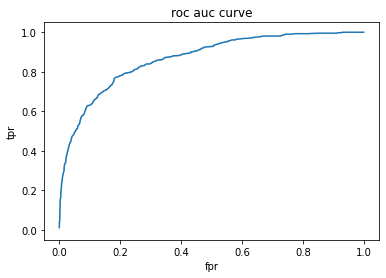

In [57]:
res = pd.DataFrame({'fpr' : fpr, 'tpr':tpr,'thresholds':thresholds })
plt.title('roc auc curve')
sns.lineplot(x=res['fpr'], y = res['tpr'])

In [58]:
#найдем трешхолд, где tpr максимальный, а fpr минимальный
res['res'] = res.fpr - res.tpr
res.sort_values(by ='res')

,fpr,tpr,thresholds,res
263,0.182105,0.769976,0.498280,-0.587871
265,0.184625,0.772397,0.497100,-0.587772
261,0.180844,0.767554,0.499463,-0.586710
262,0.182105,0.767554,0.498400,-0.585450
264,0.184625,0.769976,0.497250,-0.585351
...,...,...,...,...
548,0.994959,1.000000,0.092445,-0.005041
549,0.997480,1.000000,0.087617,-0.002520
1,0.000000,0.002421,0.971651,-0.002421
0,0.000000,0.000000,1.971651,0.000000


In [59]:
x_valid['probs'] = probs[:,1]

In [60]:
x_valid['pred'] = (x_valid['probs'] > 0.498280)*1

In [61]:
x_valid.join(y_valid).sample(10)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male,probs,pred,exited
customerid,,,,,,,,,,,,,,
15736112,519,57,2.0,119035.35,2,1,1,29871.79,0,1,0,0.532835,1,0
15570004,850,31,3.0,0.00,2,1,0,121866.87,0,0,1,0.129878,0,0
15681274,726,56,2.0,105473.74,1,1,1,46044.70,0,1,0,0.610633,1,0
15570379,669,51,5.0,88827.53,1,0,0,85250.77,0,1,1,0.755199,1,1
15757306,738,49,5.0,0.00,3,1,1,65066.48,0,1,1,0.649585,1,1
15743673,551,27,2.0,113873.22,1,1,1,85129.77,0,1,1,0.201536,0,1
15658240,554,44,9.0,135814.70,2,0,0,115091.38,0,0,0,0.513553,1,0
15624323,642,36,4.0,0.00,2,1,1,195224.91,0,0,1,0.139060,0,0
15671124,599,25,6.0,120383.41,1,1,1,24903.09,0,0,1,0.214060,0,0


In [62]:
f1_score(y_valid, x_valid['pred'])

0.623529411764706

если чуть-чуть подвинуть treshold, то немного прибавляется f1 score

практически стандартный трешхолд неплохо сработал, хорошо вытянулся recall

In [63]:
print(classification_report(y_valid, x_valid['pred']))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87      1587
           1       0.52      0.77      0.62       413

    accuracy                           0.81      2000
   macro avg       0.73      0.79      0.75      2000
weighted avg       0.85      0.81      0.82      2000



## итоговая модель 

In [64]:
#посмотрим как лучшая модель отработала на тестовых данных
pred = best_model_upsampling_rfm.predict(x_test)

In [65]:
f1_score(y_test, pred)

0.6130653266331658

In [66]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      0.82      0.87      1607
           1       0.51      0.78      0.61       393

    accuracy                           0.81      2000
   macro avg       0.72      0.80      0.74      2000
weighted avg       0.85      0.81      0.82      2000



In [67]:
roc_auc_score(y_test, pred)

0.795632498404721

лучшая модель неплохо показала себя на тестовых данных 